# ML Pipeline Preparation
Here I create a machine learning pipeline.
### 1. Import libraries and load data from database.
The steps I will folow will be: 
- Import the necessary Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

import re
import sqlalchemy 

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import *
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('words')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('wordnet')

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix, make_scorer, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
import pickle

[nltk_data] Downloading package words to
[nltk_data]     /Users/michaelreinhardme.com/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelreinhardme.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michaelreinhardme.com/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/michaelreinhardme.com/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelreinhardme.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/michaelreinhardme.com/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
print(f'The nltk version is {nltk.__version__}.')
# print('The scikit-learn version is {}.'.format(sklearn.__version__))
print(f'The sklearn version is {sklearn.__version__}')
# print(f'The version of pickle is {pickle.__version__}')

The nltk version is 3.4.4.
The sklearn version is 0.21.2


In [3]:
#I load the data from the database
#sqlite:///
engine = sqlalchemy.create_engine('sqlite:///data/DisasterResponse.db')

#read it into a Pandas DataFrame
df = pd.read_sql_table('disaster', engine) 

In [4]:
#inspect
df.tail()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
26172,30261,The training demonstrated how to enhance micro...,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26173,30262,A suitable candidate has been selected and OCH...,None,news,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26174,30263,"Proshika, operating in Cox's Bazar municipalit...",None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26175,30264,"Some 2,000 women protesting against the conduc...",None,news,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
26176,30265,A radical shift in thinking came about as a re...,None,news,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(26177, 40)

So there are 26,177 observations and 40 variables, just like in the last notebook. Which is good. 

Starting with the fifth (zero based indexing) column, 'request', till the 40th, the variables represent a one-hot encoding of message classifications. There are qualitative variables, 'genre' and 'related', that are we are going to leave out of our analysis for the time being. The 'original' messages is just that, the original message, often in a foreign language. 

Now we get the value counts of the qualitative variables:

In [6]:
for i in ['genre','related']:
    print(f'the value counts for "{i}" are:\n{df[i].value_counts()}\n')

the value counts for "genre" are:
news      13036
direct    10747
social     2394
Name: genre, dtype: int64

the value counts for "related" are:
1    19873
0     6117
2      187
Name: related, dtype: int64



#### Split the data into independent and dependent variables
For the independent variable we are going to use the message itself. For the dependent variable we are going to use the 35 categorizations of the messages. Thus the usual situation where there are numerous independent variable and one dependent variable is, for the time being, reversed. We will subsequently, in the process of turning the text content of 'message' into analyzable data, greatly increase the dimensionality of the independent variable.

In [7]:
X = df.loc[:,'message']
y = df.iloc[:,4:]

In [8]:
X.shape

(26177,)

In [9]:
y.shape

(26177, 36)

In [10]:
type(X)

pandas.core.series.Series

In [11]:
y.columns.values

array(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers',
       'other_infrastructure', 'weather_related', 'floods', 'storm',
       'fire', 'earthquake', 'cold', 'other_weather', 'direct_report'],
      dtype=object)

In [63]:
for i in df.columns[5:]:
    print(y[i].sum())

4463
118
10841
2081
1312
723
471
858
0
1669
2917
2309
404
603
298
874
1192
3439
1701
1198
1329
532
159
283
120
309
1147
7283
2148
2440
282
2452
529
1373
5066


In [ ]:
# extract data needed for visuals, first graph
genre_proportions = df.groupby('genre').count()['message']/len(df)
genre_names = list(genre_proportions.index)

In [72]:
df.columns[4:]

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

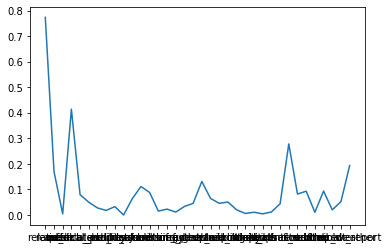

In [77]:
x_values = []
y_values = []
for i in df.columns[4:]:
    x_values.append(i)
    y_values.append(df[i].sum()/len(df))
    
plt.plot(x_values, y_values)

### 2. Write a tokenization function to process your text data

In [12]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
pstemmer = nltk.PorterStemmer()

In [13]:
import re
url_regex = 'http[s]?://(?:[a-zA-Z][0-9]|[$-_@.&+]|[!*\(\),]|[?:%[0-9a-fA-F][0-9a-fA-F])'


In [14]:
def tokenize(text, lemmatize='l'):
    #remove urs and replace with placeholder
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, 'url_placeholder')
    
    #normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    #tokenize text
    tokens = word_tokenize(text)
    
    if lemmatize=='l':
        #lemmatize andremove stop words
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    if lemmatize=='p':
        #stem the works
        tokens = [pstemmer.stem(word) for word in tokens]
    
    if lemmatize=='lp':
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        tokens = [pstemmer.stem(word) for word in tokens]

    if lemmatize=='pl':
        tokens = [pstemmer.stem(word) for word in tokens]
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
        

    return tokens

In [15]:
X_tokenized = X.apply(lambda x: tokenize(x))

In [16]:
print(X_tokenized.head())
print(type(X_tokenized))
print(X_tokenized.index)
print(X_tokenized.values[:2])
print(X_tokenized.shape)

0    [weather, update, cold, front, cuba, could, pa...
1                                          [hurricane]
2                             [looking, someone, name]
3    [un, report, leogane, 80, 90, destroyed, hospi...
4    [say, west, side, haiti, rest, country, today,...
Name: message, dtype: object
<class 'pandas.core.series.Series'>
RangeIndex(start=0, stop=26177, step=1)
[list(['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti'])
 list(['hurricane'])]
(26177,)


We won't use `X_tokenized` in the analysis but create it to better understand what is going on. So we see that `X_tokenized` is a list pandas Series of lists, each list containing the words in a tweet. Since the list is still just counted as one object the size of the data set has not increased. We can see the effects of lemmatization and stemming in words like 'hurrican' and 'updat'. This will reduce the number of words that the algorithm has to deal will. Lowering the dimensionality of the data set will reduce the noise that that goes into the model. 

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [17]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list[0]:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
            
            
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [19]:
# pipeline = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultiOutputClassifier(RandomForestClassifier()))
# ])

# 'clf__estimator__max_features': 'log2',
#  'clf__estimator__min_samples_split': 2,
#  'clf__estimator__n_estimators': 250,
#  'vect__ngram_range': (1, 2)}

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(\
                    RandomForestClassifier(\
                        random_state=100, n_estimators=250,\ 
                        min_samples_split=2,\
                        max_features='log2')))
])

Abortive attempt at constucting a loop to test the different settings for tokenize.

In [38]:
# options = ['l','p','lp','pl','']

# for i in options:
#     tokenize = tokenize(X_train, lemmatize=i)
#     pipeline.fit(X_train, y_train)
#     y_pred = pipeline.predict(X_test)
#     print(accuracy_score(y_test, y_pred))
#     print(f'the accurracy score for tokenise {i} = {accuracy_score(y_test, y_pred)}')

I have not been able to get the `FeatureUnion` feature to work so I am leaving it out for now, though I would like to include it in future versions. The `StartingVerbExtractor` doesn't seem all that vital but I could be wrong. Also, I would like to include the quantitative variables 'genre' and 'related' in the analysis, though I don't think that will require `FeatureUnion`. 

In [165]:
# pipeline1 = Pipeline([
#     ('features', FeatureUnion([

#         ('text_pipeline', Pipeline([
#             ('vect', CountVectorizer(tokenizer=tokenize)),
#             ('tfidf', TfidfTransformer())
#         ])),

#         ('starting_verb', StartingVerbExtractor())
#     ])),

#     ('clf', MultiOutputClassifier(RandomForestClassifier()))
    
#     ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [21]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                 MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                  

In [22]:
y_pred = pipeline.predict(X_test)

In [32]:
y_pred.shape

(6545, 36)

In [24]:
accuracy_score(y_test, y_pred)

ValueError: multiclass-multioutput is not supported

So for just lemmatizing the text I got 0.384 accuracy. For just stemming I got 0.378. For stemming and then lemmatizing I got 0.383. And for lemmatising and then stemming I got 0.384 again. For reference, skipping both lemmatizing and stemming got 0.385, so on this evidence it is best to not use either. 

So this dry run of running random forest without any parameter tuning does just 38% accuracy. That is not very good, though there were 35 categories into which a message could be categorized. 

In [25]:
len(y_test.columns)

36

In [26]:
print(classification_report(y_test, y_pred, target_names=y_test.columns))

ValueError: multiclass-multioutput is not supported

In [27]:
multilabel_confusion_matrix(y_test, y_pred)

ValueError: multiclass-multioutput is not supported

In [34]:
evaluate_model(pipeline, X_test, y_test, category_names)

Accuracy Score: 0.9381291910703675


### 6. Improve your model
Use grid search to find better parameters. 

In [171]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf__estimator__random_state', 'clf__estimator__verbose', 'clf__

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [201]:
def tokenize_M(text, lemma=True, remove_stop=True, remove_short=True):
    '''
    input: (
        text: 
        lemma: True if lemmatize word, 
        remove_stop: True if remove stopwords  
        remove_short: True if remove short words > 2
            )
    Function tokenizes the text 
    output: (
        returns cleaned tokens in list 
            )
    '''
    # stopword list 
    STOPWORDS = list(set(stopwords.words('english')))
    # initialize lemmatier
    lemmatizer = WordNetLemmatizer()
    # split string into words (tokens)
    tokens = word_tokenize(text)
    # remove short words
    if remove_short: tokens = [token for token in tokens if len(token) > 2]
    # put words into base form
    if lemma: tokens = [lemmatizer.lemmatize(token).lower().strip() for token in tokens]
    # remove stopwords
    if remove_stop: tokens = [token for token in tokens if token not in STOPWORDS]
    # return data 
    return tokens


In [167]:
# pipeline = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultiOutputClassifier(RandomForestClassifier()))
# ])

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize_M)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=100)))
])

In [155]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf__estimator__random_state', 'clf__estimator__verbose', 'clf__

In [157]:
# parameters = {
#         'tfidf__smooth_idf': [True, False],
#         'clf__estimator__n_estimators': [20, 25],
#         'clf__estimator__max_depth' : [1, 2, 3]
#     }
param_grid = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'clf__estimator__min_samples_split': [2, 4],
        'clf__estimator__max_features': ['log2', 'auto'],
        'clf__estimator__n_estimators': [100, 250],
    }

In [158]:
cv = GridSearchCV(pipeline, param_grid=param_grid, verbose=2, n_jobs=4, cv=3)

Now fit the model

In [159]:
cv.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 306.4min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 436.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [160]:
y_pred = cv.predict(X_test)
cv.best_params_

{'clf__estimator__max_features': 'log2',
 'clf__estimator__min_samples_split': 2,
 'clf__estimator__n_estimators': 250,
 'vect__ngram_range': (1, 2)}

In [161]:
print(accuracy_score(y_test, y_pred))
print(print(classification_report(y_test, y_pred, target_names=y_test.columns)))

0.4343773873185638
                        precision    recall  f1-score   support

               request       0.88      0.35      0.50      1130
                 offer       0.00      0.00      0.00        32
           aid_related       0.86      0.39      0.54      2734
          medical_help       0.40      0.00      0.01       535
      medical_products       0.75      0.01      0.02       318
     search_and_rescue       0.00      0.00      0.00       180
              security       0.00      0.00      0.00       117
              military       0.00      0.00      0.00       205
           child_alone       0.00      0.00      0.00         0
                 water       1.00      0.09      0.16       430
                  food       0.90      0.20      0.33       715
               shelter       0.96      0.04      0.08       598
              clothing       0.33      0.01      0.02        87
                 money       0.80      0.03      0.05       141
        missing_peop

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [162]:
for i, label in enumerate(y_test.columns):
    print(label)
    print(confusion_matrix(y_test.values[:,i], y_pred[:,i]))
#     if i == 4:
#         break

request
[[5363   52]
 [ 731  399]]
offer
[[6513    0]
 [  32    0]]
aid_related
[[3637  174]
 [1667 1067]]
medical_help
[[6007    3]
 [ 533    2]]
medical_products
[[6226    1]
 [ 315    3]]
search_and_rescue
[[6363    2]
 [ 180    0]]
security
[[6428    0]
 [ 117    0]]
military
[[6339    1]
 [ 205    0]]
child_alone
[[6545]]
water
[[6115    0]
 [ 392   38]]
food
[[5814   16]
 [ 573  142]]
shelter
[[5946    1]
 [ 572   26]]
clothing
[[6456    2]
 [  86    1]]
money
[[6403    1]
 [ 137    4]]
missing_people
[[6480    0]
 [  65    0]]
refugees
[[6299    0]
 [ 246    0]]
death
[[6231    0]
 [ 307    7]]
other_aid
[[5681    6]
 [ 849    9]]
infrastructure_related
[[6080    0]
 [ 465    0]]
transport
[[6260    0]
 [ 285    0]]
buildings
[[6190    0]
 [ 353    2]]
electricity
[[6420    0]
 [ 125    0]]
tools
[[6510    0]
 [  35    0]]
hospitals
[[6468    0]
 [  77    0]]
shops
[[6499    0]
 [  46    0]]
aid_centers
[[6461    0]
 [  84    0]]
other_infrastructure
[[6239    0]
 [ 306    0]]
w

In [33]:
category_names = y_test.columns
def evaluate_model(cv, X_test, y_test, category_names):
    '''
    input: (
        model: trained model 
        X_test: Test features 
        Y_test: Test labels 
        category_names: names of lables
            )
    Evaluate a trained model against a test dataset
    '''
    # get predictions 
    y_preds = cv.predict(X_test)
    # print classification report
#     print(classification_report(y_preds, y_test.values, target_names=category_names))
    # print raw accuracy score 
    print('Accuracy Score: {}'.format(np.mean(y_test.values == y_preds)))


In [164]:
evaluate_model(cv, X_test, y_test, category_names)

                        precision    recall  f1-score   support

               request       0.35      0.88      0.50       451
                 offer       0.00      0.00      0.00         0
           aid_related       0.39      0.86      0.54      1241
          medical_help       0.00      0.40      0.01         5
      medical_products       0.01      0.75      0.02         4
     search_and_rescue       0.00      0.00      0.00         2
              security       0.00      0.00      0.00         0
              military       0.00      0.00      0.00         1
           child_alone       0.00      0.00      0.00         0
                 water       0.09      1.00      0.16        38
                  food       0.20      0.90      0.33       158
               shelter       0.04      0.96      0.08        27
              clothing       0.01      0.33      0.02         3
                 money       0.03      0.80      0.05         5
        missing_people       0.00      

In [196]:
#import xgboost as xgb

In [197]:
#clf = xgb.XGBClassifier()

In [198]:
# pipeline = Pipeline([
#     ('vect', CountVectorizer(tokenizer=tokenize)),
#     ('tfidf', TfidfTransformer()),
#     ('clf', MultiOutputClassifier(xgb.XGBClassifier()))
# ])

In [199]:
# parameters = {
#         'vect__max_features': [1000, 1500, 2000],
#         'tfidf__norm': ['l2'],
#         'tfidf__sublinear_tf': [ False],
#         'tfidf__smooth_idf': [False],
#         'clf__estimator__max_depth': [3,5]
#     }

# cv = GridSearchCV(pipeline, parameters)

In [200]:
# cv.fit(X_train, y_train)

In [201]:
# pred = cv.predict(X_test)

In [202]:
# cv.best_params_

In [203]:
# accuracy_score(y_test, y_pred)

In [205]:
# for i, label in enumerate(y_test.columns):
#     print(label)
#     print(confusion_matrix(y_test.values[:,i], y_pred[:,i] ))

### 9. Export your model as a pickle file

In [165]:
disaster_model = 'models/finalized_model.sav'
pickle.dump(cv, open(disaster_model, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.